In [1]:
# Bu notebook:

# Data/Processed/splits_multilabel/{train,val,test}.csv ni o‘qiydi

# label balans (train/val/test + overall), label density/cardinality

# label co-occurrence (eng ko‘p juftliklar)

# label correlation heatmap

# text length (char/token) statistikasi + plot

# split leakage (bir xil textlar train/val/test’da takrorlanganmi?)

# EDA natijalarini .../eda_outputs/ ga CSV qilib saqlaydi

# ✅ CELL 1 — Imports + Config + Paths
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

SEED = 42
TEXT_COL = "REAC_pt_symptom_v2"

# Project root topish
CWD = Path.cwd()
if (CWD / "Data").exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / "Data").exists():
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

SPLIT_DIR = PROJECT_ROOT / "Data" / "Processed" / "splits_multilabel_noleakage"
TRAIN_CSV = SPLIT_DIR / "train.csv"
VAL_CSV   = SPLIT_DIR / "val.csv"
TEST_CSV  = SPLIT_DIR / "test.csv"

EDA_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
EDA_OUT.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SPLIT_DIR:", SPLIT_DIR)
print("Exists:", TRAIN_CSV.exists(), VAL_CSV.exists(), TEST_CSV.exists())
print("EDA_OUT:", EDA_OUT)

PROJECT_ROOT: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract
SPLIT_DIR: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\Data\Processed\splits_multilabel_noleakage
Exists: True True True
EDA_OUT: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\eda_outputs


In [2]:
# CELL 2 — Load splits + detect labels
df_train = pd.read_csv(TRAIN_CSV, low_memory=False)
df_val   = pd.read_csv(VAL_CSV, low_memory=False)
df_test  = pd.read_csv(TEST_CSV, low_memory=False)

# y_ label ustunlar (y_labels emas)
y_cols = sorted([c for c in df_train.columns if c.startswith("y_") and c != "y_labels"])

assert TEXT_COL in df_train.columns, f"Missing {TEXT_COL} in train"
assert all(c in df_val.columns for c in y_cols), "val missing some y_ cols"
assert all(c in df_test.columns for c in y_cols), "test missing some y_ cols"

print("Shapes:", df_train.shape, df_val.shape, df_test.shape)
print("Num labels:", len(y_cols))
print("Labels:", y_cols)
df_train[[TEXT_COL] + y_cols].head(2)

Shapes: (201176, 24) (24410, 24) (24164, 24)
Num labels: 21
Labels: ['y_cardiovascular', 'y_dermatologic', 'y_edema_swelling', 'y_gastrointestinal', 'y_general_systemic', 'y_hematologic', 'y_hepatic', 'y_hypersensitivity_allergy', 'y_infections', 'y_injection_site', 'y_injury_accident', 'y_metabolic_endocrine', 'y_musculoskeletal', 'y_neurological', 'y_ocular_visual', 'y_pain_general', 'y_pregnancy_reproductive', 'y_psychiatric', 'y_renal', 'y_respiratory', 'y_urinary']


,REAC_pt_symptom_v2,y_cardiovascular,y_dermatologic,y_edema_swelling,y_gastrointestinal,y_general_systemic,y_hematologic,y_hepatic,y_hypersensitivity_allergy,y_infections,y_injection_site,y_injury_accident,y_metabolic_endocrine,y_musculoskeletal,y_neurological,y_ocular_visual,y_pain_general,y_pregnancy_reproductive,y_psychiatric,y_renal,y_respiratory,y_urinary
0,Injection site reaction; General physical heal...,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0
1,Internal haemorrhage; Injury; Pain; Depression...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0


In [3]:
#CELL 3 — Basic sanity (0/1, empty text, label density/cardinality)
def sanity_block(df, name):
    print("\n" + "="*90)
    print(f"[{name}]")
    print("="*90)

    # text clean check
    empty_text = int((df[TEXT_COL].fillna("").astype(str).str.strip() == "").sum())
    print("rows:", len(df))
    print("empty text:", empty_text)

    # y binary check
    Y = df[y_cols].copy()
    vals = set(pd.unique(Y.to_numpy().ravel()))
    print("unique values in Y:", vals)
    if not vals.issubset({0,1}):
        bad = sorted([v for v in vals if v not in {0,1}])
        raise ValueError(f"{name}: Y has non-binary values: {bad}")

    # label count per row
    label_count = Y.sum(axis=1)
    print("label_count min/mean/max:",
          int(label_count.min()),
          float(label_count.mean().round(3)),
          int(label_count.max()))
    print("0-label rows:", int((label_count==0).sum()))

    # cardinality distribution (how many labels per row)
    card = label_count.value_counts().sort_index()
    card_df = pd.DataFrame({"labels_per_row": card.index, "count": card.values})
    display(card_df.head(15))

    return Y, label_count

Y_train, lc_train = sanity_block(df_train, "TRAIN")
Y_val,   lc_val   = sanity_block(df_val,   "VAL")
Y_test,  lc_test  = sanity_block(df_test,  "TEST")


[TRAIN]
rows: 201176
empty text: 0
unique values in Y: {np.int64(0), np.int64(1)}
label_count min/mean/max: 1 2.125 18
0-label rows: 0


,labels_per_row,count
0,1,103342
1,2,46727
2,3,22846
3,4,11427
4,5,6387
5,6,3542
6,7,2244
7,8,1416
8,9,863
9,10,657



[VAL]
rows: 24410
empty text: 0
unique values in Y: {np.int64(0), np.int64(1)}
label_count min/mean/max: 1 2.173 16
0-label rows: 0


,labels_per_row,count
0,1,10357
1,2,8400
2,3,2458
3,4,1266
4,5,696
5,6,399
6,7,289
7,8,166
8,9,106
9,10,73



[TEST]
rows: 24164
empty text: 0
unique values in Y: {np.int64(0), np.int64(1)}
label_count min/mean/max: 1 2.147 17
0-label rows: 0


,labels_per_row,count
0,1,12488
1,2,5346
2,3,2829
3,4,1438
4,5,725
5,6,442
6,7,274
7,8,185
8,9,121
9,10,90


,label,train_%,val_%,test_%,overall_%
0,gastrointestinal,21.843,20.123,20.328,21.528
1,pain_general,18.221,30.901,17.365,19.377
2,dermatologic,18.421,18.333,22.236,18.782
3,neurological,17.963,16.006,16.901,17.669
4,general_systemic,17.278,13.744,16.872,16.894
5,infections,15.137,13.609,13.259,14.806
6,respiratory,12.842,10.406,11.650,12.489
7,cardiovascular,11.209,10.356,12.564,11.257
8,hematologic,10.151,9.402,14.087,10.459
9,musculoskeletal,9.752,7.698,8.248,9.406


Saved CSV: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\eda_outputs\label_prevalence_by_split.csv
Saved figure: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\baseline_EDA\label_prevalence_overall_top.png


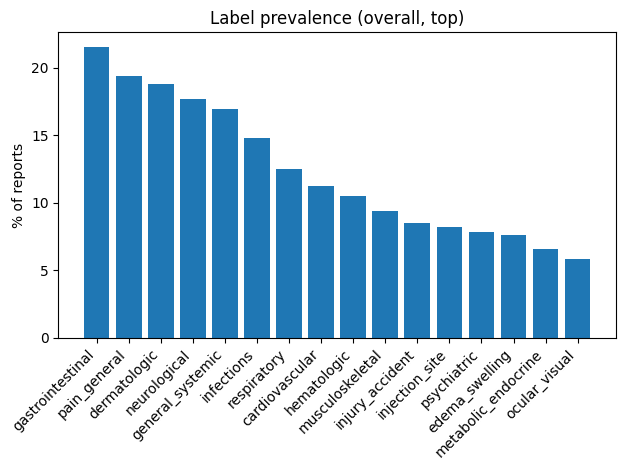

In [4]:
# CELL 4 — Label prevalence (train/val/test + overall) + plot + save (UPDATED)

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

def prevalence(df):
    return (df[y_cols].mean() * 100).round(3)

prev_train = prevalence(df_train)
prev_val   = prevalence(df_val)
prev_test  = prevalence(df_test)
prev_all   = prevalence(pd.concat([df_train, df_val, df_test], axis=0))

prev_table = pd.DataFrame({
    "label": y_cols,
    "train_%": prev_train.values,
    "val_%": prev_val.values,
    "test_%": prev_test.values,
    "overall_%": prev_all.values,
})

# label nomini chiroyliroq ko‘rsatish uchun
prev_table["label"] = prev_table["label"].str.replace("^y_", "", regex=True)

prev_table = prev_table.sort_values("overall_%", ascending=False).reset_index(drop=True)
display(prev_table)

# =========================
# NEW SAVE LOCATIONS
# =========================
TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"

TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

# Save CSV -> results/tables/eda_outputs
csv_path = TABLES_OUT / "label_prevalence_by_split.csv"
prev_table.to_csv(csv_path, index=False, encoding="utf-8-sig")
print("Saved CSV:", csv_path)

# Plot + Save figure -> visuals/baseline_EDA
top_n = min(16, len(prev_table))
plt.figure()
plt.bar(prev_table["label"].head(top_n), prev_table["overall_%"].head(top_n))
plt.xticks(rotation=45, ha="right")
plt.title("Label prevalence (overall, top)")
plt.ylabel("% of reports")
plt.tight_layout()

fig_path = VIS_OUT / "label_prevalence_overall_top.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()

,label,train_%,val_%,test_%,overall_%,abs_diff_train_test
0,hematologic,10.151,9.402,14.087,10.459,3.936
1,dermatologic,18.421,18.333,22.236,18.782,3.815
2,hypersensitivity_allergy,4.439,3.159,8.128,4.671,3.689
3,infections,15.137,13.609,13.259,14.806,1.878
4,gastrointestinal,21.843,20.123,20.328,21.528,1.515
5,musculoskeletal,9.752,7.698,8.248,9.406,1.504
6,cardiovascular,11.209,10.356,12.564,11.257,1.355
7,respiratory,12.842,10.406,11.650,12.489,1.192
8,metabolic_endocrine,6.830,5.145,5.728,6.559,1.102
9,neurological,17.963,16.006,16.901,17.669,1.062


Saved CSV: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\eda_outputs\label_prevalence_drift_train_vs_test.csv
Saved figure: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\baseline_EDA\label_prevalence_drift_train_vs_test_table.png


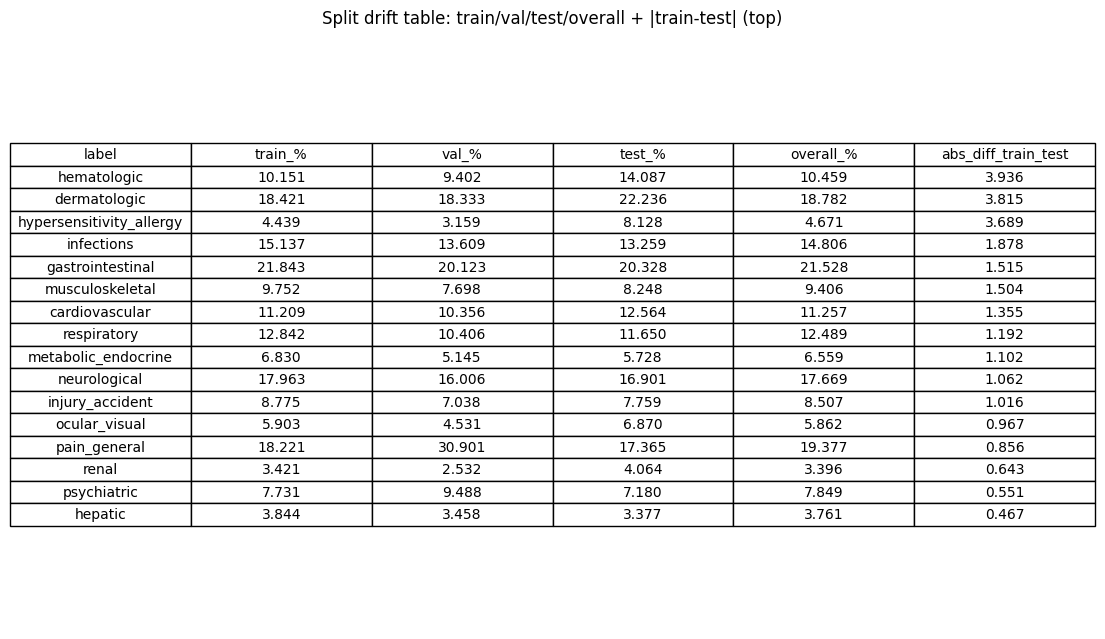

In [5]:
# CELL 5 — Drift visual as TABLE (CSV ko‘rinishida) + save

from pathlib import Path
import matplotlib.pyplot as plt

TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

# --- Drift table ---
drift = prev_table.copy()
drift["abs_diff_train_test"] = (drift["train_%"] - drift["test_%"]).abs().round(3)
drift = drift.sort_values("abs_diff_train_test", ascending=False).reset_index(drop=True)

display(drift)

csv_path = TABLES_OUT / "label_prevalence_drift_train_vs_test.csv"
drift.to_csv(csv_path, index=False, encoding="utf-8-sig")
print("Saved CSV:", csv_path)

# --- Visual: TABLE image (xuddi CSV ko‘rinishida) ---
top_n = min(16, len(drift))
plot_df = drift.head(top_n).copy()

# chiroyli format (3 decimals)
for c in ["train_%", "val_%", "test_%", "overall_%", "abs_diff_train_test"]:
    plot_df[c] = plot_df[c].map(lambda x: f"{x:.3f}")

# Figure size (qatorlar soniga mos)
nrows, ncols = plot_df.shape
fig_w = 14
fig_h = max(4, 0.45 * (nrows + 1))

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis("off")

table = ax.table(
    cellText=plot_df.values,
    colLabels=plot_df.columns.tolist(),
    cellLoc="center",
    colLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.35)

ax.set_title("Split drift table: train/val/test/overall + |train-test| (top)", pad=12)

fig_path = VIS_OUT / "label_prevalence_drift_train_vs_test_table.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()

In [6]:
# CELL 6 — Label co-occurrence (top pairs) + save

from pathlib import Path
import matplotlib.pyplot as plt

TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
# VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
# VIS_OUT.mkdir(parents=True, exist_ok=True)

def top_cooccurrence_pairs(Y_df, top_k=30):
    # counts: LxL
    Y = Y_df.to_numpy(dtype=np.int32)
    C = (Y.T @ Y)  # label-label counts
    np.fill_diagonal(C, 0)

    pairs = []
    L = len(y_cols)
    for i in range(L):
        for j in range(i+1, L):
            cnt = int(C[i, j])
            if cnt > 0:
                pairs.append((y_cols[i].replace("y_", "",1), y_cols[j].replace("y_", "",1), cnt))

    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:top_k]
    return pd.DataFrame(pairs, columns=["label_a", "label_b", "count"])

pairs_train = top_cooccurrence_pairs(Y_train, top_k=40)
display(pairs_train)

pairs_train.to_csv(TABLES_OUT / "top_cooccurrence_pairs_train.csv", index=False, encoding="utf-8-sig")

,label_a,label_b,count
0,gastrointestinal,pain_general,15290
1,gastrointestinal,general_systemic,12515
2,general_systemic,neurological,11388
3,general_systemic,pain_general,11230
4,gastrointestinal,neurological,10993
5,neurological,pain_general,9864
6,dermatologic,pain_general,8471
7,general_systemic,respiratory,8401
8,infections,respiratory,8285
9,general_systemic,infections,8271


Saved CSV: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\eda_outputs\label_correlation_train.csv
Saved figure: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\baseline_EDA\label_correlation_train.png


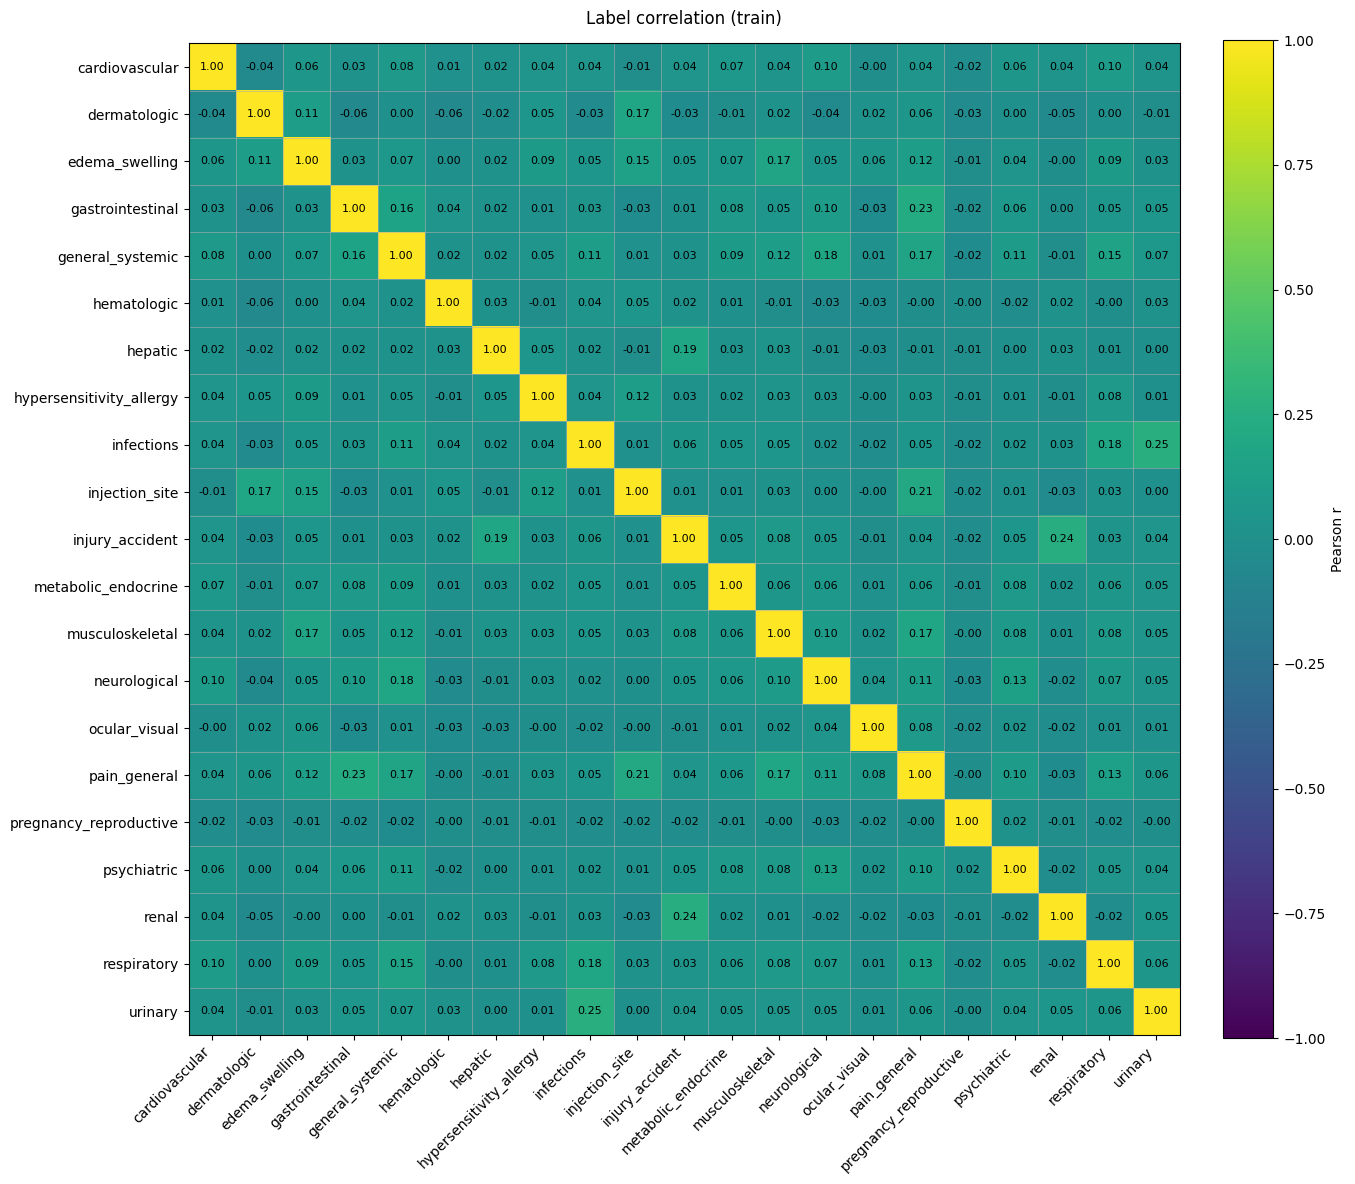

In [7]:
# CELL 7 — Label correlation heatmap (train) + save matrix (BETTER VIS)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

# --- Correlation matrix ---
corr = pd.DataFrame(np.corrcoef(Y_train.to_numpy().T), index=y_cols, columns=y_cols)
corr.index = corr.index.str.replace("^y_", "",1, regex=True)
corr.columns = corr.columns.str.replace("^y_", "",1, regex=True)

# Save matrix
csv_path = TABLES_OUT / "label_correlation_train.csv"
corr.to_csv(csv_path, encoding="utf-8-sig")
print("Saved CSV:", csv_path)

# --- Better heatmap: square + fixed range + annotated values + gridlines ---
n = corr.shape[0]

fig_w = max(10, 0.65 * n)  # labels ko‘p bo‘lsa avtomatik kattalashadi
fig_h = max(9, 0.65 * n)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

im = ax.imshow(
    corr.values,
    vmin=-1, vmax=1,            # ranglar doim bir xil ma’noda bo‘lsin
    aspect="equal",             # kvadrat bo‘lsin
    interpolation="nearest"
)

ax.set_title("Label correlation (train)", pad=14)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)

# Gridlines (ko‘zga aniq ko‘rinsin)
ax.set_xticks(np.arange(-.5, n, 1), minor=True)
ax.set_yticks(np.arange(-.5, n, 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Pearson r", rotation=90)

# Annotate correlation values (kichik n bo‘lsa chiroyli; katta bo‘lsa o‘chiramiz)
ANNOTATE_MAX_N = 21
if n <= ANNOTATE_MAX_N:
    for i in range(n):
        for j in range(n):
            val = corr.values[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()

fig_path = VIS_OUT / "label_correlation_train.png"
plt.savefig(fig_path, dpi=220, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()

,split,rows,char_len_mean,char_len_p50,char_len_p95,tok_len_mean,tok_len_p50,tok_len_p95
0,train,201176,62.491271,36.0,199.0,6.895504,4.0,22.0
1,val,24410,58.532364,31.0,188.0,6.582507,3.0,21.0
2,test,24164,63.896333,36.0,207.0,6.979060,4.0,22.0


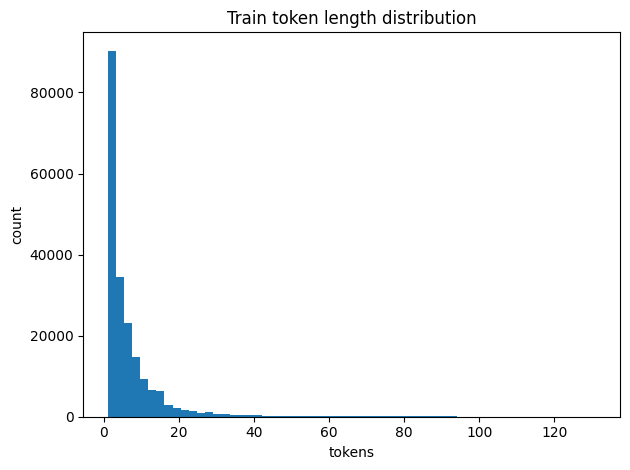

In [8]:
# CELL 8 — Text length stats (char + token) + plot + save

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

def text_stats(df, name):
    s = df[TEXT_COL].fillna("").astype(str)
    char_len = s.str.len()
    tok_len = s.str.split().apply(len)

    out = pd.DataFrame({
        "split": [name],
        "rows": [len(df)],
        "char_len_mean": [float(char_len.mean())],
        "char_len_p50": [float(char_len.quantile(0.50))],
        "char_len_p95": [float(char_len.quantile(0.95))],
        "tok_len_mean": [float(tok_len.mean())],
        "tok_len_p50": [float(tok_len.quantile(0.50))],
        "tok_len_p95": [float(tok_len.quantile(0.95))],
    })
    return out, char_len, tok_len

st_train, ch_train, tk_train = text_stats(df_train, "train")
st_val,   ch_val,   tk_val   = text_stats(df_val,   "val")
st_test,  ch_test,  tk_test  = text_stats(df_test,  "test")

text_stats_table = pd.concat([st_train, st_val, st_test], axis=0).reset_index(drop=True)
display(text_stats_table)

text_stats_table.to_csv(TABLES_OUT / "text_length_stats_by_split.csv", index=False, encoding="utf-8-sig")

# Plot (train token length)
plt.figure()
plt.hist(tk_train, bins=60)
plt.title("Train token length distribution")
plt.xlabel("tokens")
plt.ylabel("count")
plt.tight_layout()
plt.show()

,overlap_train_val,overlap_train_test,overlap_val_test,train_rows,val_rows,test_rows
0,0,0,0,201176,24410,24164


Saved CSV: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\results\tables\eda_outputs\split_leakage_exact_text_hash.csv
Saved figure: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\baseline_EDA\split_leakage_overlap_counts.png


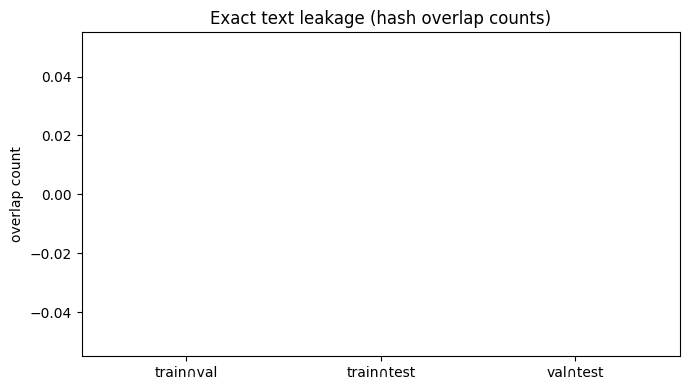

Saved figure: c:\Users\xolmu\OneDrive\Desktop\Modul Program oyi\Modul_Program3\6_project_dori_tasiri_extract\visuals\baseline_EDA\split_leakage_summary_table.png


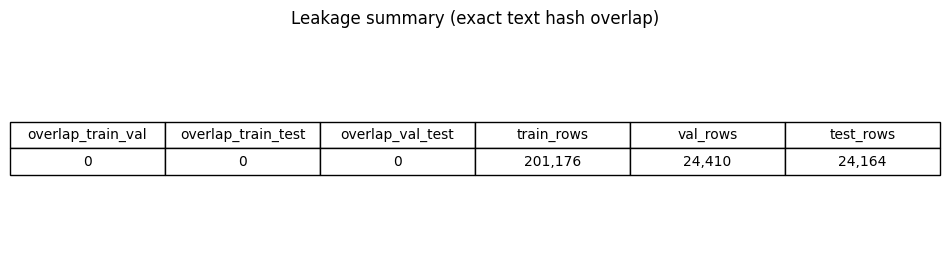

In [9]:
# CELL 9 — Leakage check (exact same text across splits) + save + VISUAL (UPDATED)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object

TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

def hash_text_series(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str)
    return hash_pandas_object(s, index=False)

h_train = hash_text_series(df_train[TEXT_COL])
h_val   = hash_text_series(df_val[TEXT_COL])
h_test  = hash_text_series(df_test[TEXT_COL])

set_train = set(h_train.values)
set_val   = set(h_val.values)
set_test  = set(h_test.values)

over_train_val  = len(set_train & set_val)
over_train_test = len(set_train & set_test)
over_val_test   = len(set_val & set_test)

leak = pd.DataFrame([{
    "overlap_train_val": over_train_val,
    "overlap_train_test": over_train_test,
    "overlap_val_test": over_val_test,
    "train_rows": len(df_train),
    "val_rows": len(df_val),
    "test_rows": len(df_test),
}])

display(leak)

csv_path = TABLES_OUT / "split_leakage_exact_text_hash.csv"
leak.to_csv(csv_path, index=False, encoding="utf-8-sig")
print("Saved CSV:", csv_path)

# =========================
# VISUAL 1: Bar chart (overlap counts)
# =========================
pairs = ["train∩val", "train∩test", "val∩test"]
counts = [over_train_val, over_train_test, over_val_test]

plt.figure(figsize=(7,4))
plt.bar(pairs, counts)
plt.title("Exact text leakage (hash overlap counts)")
plt.ylabel("overlap count")
plt.tight_layout()

fig1 = VIS_OUT / "split_leakage_overlap_counts.png"
plt.savefig(fig1, dpi=200, bbox_inches="tight")
print("Saved figure:", fig1)
plt.show()

# =========================
# VISUAL 2: Table image (CSV ko‘rinishida)
# =========================
plot_df = leak.copy()
# hammasini string formatga keltiramiz (table chiroyli chiqsin)
for c in plot_df.columns:
    plot_df[c] = plot_df[c].map(lambda x: f"{int(x):,}" if isinstance(x, (int, np.integer)) else str(x))

fig, ax = plt.subplots(figsize=(12, 2.8))
ax.axis("off")
tbl = ax.table(
    cellText=plot_df.values,
    colLabels=plot_df.columns.tolist(),
    cellLoc="center",
    colLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.6)

ax.set_title("Leakage summary (exact text hash overlap)", pad=12)

fig2 = VIS_OUT / "split_leakage_summary_table.png"
plt.savefig(fig2, dpi=220, bbox_inches="tight")
print("Saved figure:", fig2)
plt.show()




# Bu CELL 9 kodining vazifasi: train/val/test splitlar orasida bir xil simptom matni (REAC_pt_symptom) aynan takrorlanib qolganmi yoki yo‘qmi — shuni tekshiradi va natijani CSV + 2 ta rasm qilib saqlaydi.

# Quyma-qadam:

# 1) Har splitdagi matnni “hash”ga aylantiradi

# hash_text_series() funksiyasi har bir matnni 64-bit hash (raqam)ga aylantiradi.

# Hash ishlatish sababi: matnlarni to‘g‘ridan-to‘g‘ri solishtirishdan tezroq.

# Natija:

# h_train, h_val, h_test — har bir qatordagi text’ning hash qiymatlari.

# 2) Train/Val/Test orasidagi overlap’ni hisoblaydi

# set_train & set_val → train va val’da aynan bir xil text nechta bor

# set_train & set_test → train va test overlap

# set_val & set_test → val va test overlap

# Bu overlap’lar:

# over_train_val, over_train_test, over_val_test

# 3) Natijani jadvalga joylaydi va CSV saqlaydi

# leak degan DataFrame ichida:

# overlap counts (nechta duplicate text bor)

# har splitda jami nechta row bor

# Buni results/tables/eda_outputs/split_leakage_exact_text_hash.csv ga saqlaydi.

# 4) 2 ta vizual chiqaradi va saqlaydi

# VISUAL 1 — Bar chart

# 3 ta ustun: train∩val, train∩test, val∩test

# overlap sonini ko‘rsatadi

# visuals/baseline_EDA/split_leakage_overlap_counts.png ga saqlaydi

# VISUAL 2 — Table image

# leak jadvalini xuddi CSV ko‘rinishida rasm qiladi

# visuals/baseline_EDA/split_leakage_summary_table.png ga saqlaydi

# Nega bu muhim?

# Agar train va testda bir xil text ko‘p bo‘lsa:

# model testni “yodlab” qo‘ygan bo‘lishi mumkin

# metrikalar sun’iy yuqori chiqadi (data leakage)

# Shu kod bizning pipeline’ning halolligini tekshiradi.

In [10]:
# bu chiqgan natija shuni bildiradi: REAC_pt_symptom matni aynan bir xil bo‘lgan recordlar splitlar orasida takrorlanib qolgan.

# Sizdagi sonlar:

# train ∩ val = 2347

# train ∩ test = 2461

# val ∩ test = 1004

# Bu qiymatlar “unikal textlar” (unikal hash) bo‘yicha overlap. Ya’ni kamida 2461 xil simptom-matn testda ham bor va train’da ham bor.

# Bu yomonmi?

# “Project buzildi” darajada emas.

# Lekin test metrikalar biroz optimistik bo‘lishi mumkin, chunki model testda “oldin ko‘rgan aynan text”ga duch keladi.

# 1) Avval real ta’sirini aniq o‘lchaymiz (test row’larining necha % i train’da bor?)

# Quyidagi cell’ni ishlating (row-level foizni beradi):

from pandas.util import hash_pandas_object

def text_hash(s: pd.Series) -> pd.Series:
    return hash_pandas_object(s.fillna("").astype(str), index=False)

htr = text_hash(df_train[TEXT_COL])
hva = text_hash(df_val[TEXT_COL])
hte = text_hash(df_test[TEXT_COL])

set_tr = set(htr.values)
set_va = set(hva.values)
set_te = set(hte.values)

pct_test_seen_in_train = (hte.isin(set_tr).mean() * 100)
pct_val_seen_in_train  = (hva.isin(set_tr).mean() * 100)

print(f"Test rows whose EXACT text is in TRAIN: {pct_test_seen_in_train:.2f}%")
print(f"Val  rows whose EXACT text is in TRAIN: {pct_val_seen_in_train:.2f}%")

# Bu sizga “overlap count” emas, haqiqiy splitdagi qatorlarning necha foizi leakage ekanini ko‘rsatadi.

Test rows whose EXACT text is in TRAIN: 0.00%
Val  rows whose EXACT text is in TRAIN: 0.00%


In [11]:
# CELL 10 — Top terms (TF-IDF) from train sample (tez va foydali) + save

# Bu cell og‘ir bo‘lishi mumkin, shuning uchun sample bilan ishlaydi.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object

TABLES_OUT = PROJECT_ROOT / "results" / "tables" / "eda_outputs"
VIS_OUT    = PROJECT_ROOT / "visuals" / "baseline_EDA"
TABLES_OUT.mkdir(parents=True, exist_ok=True)
VIS_OUT.mkdir(parents=True, exist_ok=True)

from sklearn.feature_extraction.text import TfidfVectorizer

SAMPLE_N = 50000  # xohlasangiz 20000 qiling
rng = np.random.default_rng(SEED)

train_idx = rng.choice(len(df_train), size=min(SAMPLE_N, len(df_train)), replace=False)
sample_text = df_train.iloc[train_idx][TEXT_COL].fillna("").astype(str).values

tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=5,
    max_features=60000
)

X = tfidf.fit_transform(sample_text)
feat = np.array(tfidf.get_feature_names_out())

# Top terms overall by mean tfidf
mean_w = np.asarray(X.mean(axis=0)).ravel()
top_idx = mean_w.argsort()[::-1][:60]
top_terms = pd.DataFrame({
    "term": feat[top_idx],
    "mean_tfidf": mean_w[top_idx].round(6)
})

display(top_terms.head(30))
top_terms.to_csv(TABLES_OUT / "top_terms_tfidf_train_sample.csv", index=False, encoding="utf-8-sig")



# Bu kod train split’dagi matnlarda eng “ko‘p uchraydigan va muhim” (TF-IDF bo‘yicha) so‘z/ibora(1–2 so‘zli n-gram) larni topib, ro‘yxat qilib beradi.

# Aniq nima bo‘layapti:

# Train’dan 50,000 ta matn sample oladi (REAC_pt_symptom).

# Maqsad: butun 300k+ni emas, tezroq EDA qilish.

# TfidfVectorizer(ngram_range=(1,2)):

# Matndan unigram (1 so‘z) va bigram (2 so‘z) larni chiqaradi.

# min_df=5: kamida 5 ta hujjatda uchramagan term’larni tashlaydi (shovqin kamayadi).

# max_features=60000: eng muhim 60k term’ni saqlaydi (xotira/tezlik uchun).

# X = tfidf.fit_transform(sample_text)

# X — (50k x 60k) ga yaqin sparse matritsa.

# Har katak: “shu matnda shu term qanchalik muhim” degan TF-IDF vazn.

# mean_w = X.mean(axis=0)

# Har bir term uchun butun sample bo‘yicha o‘rtacha TF-IDF ni hisoblaydi.

# Keyin eng kattalarini (top_idx) oladi.

# top_terms natijasi:

# term: eng yuqori o‘rtacha TF-IDF olgan so‘z/ibora

# mean_tfidf: o‘sha term’ning sample bo‘yicha o‘rtacha “muhiqlik” qiymati

# Bu EDA’da nimaga kerak?

# Dataset matni qanday til (inglizcha), qanday medical tokenlar borligini ko‘rasiz.

# Eng ko‘p “signal” berayotgan so‘z/iboralarni ko‘rib, keyingi preprocess/feature engineering’ni to‘g‘ri tanlaysiz (masalan char n-gram kerakmi, stopwords kerakmi, va hokazo).

# Agar top’da “noise” chiqsa (masalan “product”, “dose”, “off label”) — demak drop qoidangiz yetarli emas, yana tozalash kerak.

# Muhim nuance (to‘g‘ri tushunish uchun)

# Bu kod “eng ko‘p uchraydigan” so‘zlarni 100% bermaydi.
# U “ko‘p hujjatda uchraydigan + har hujjatda nisbatan muhim bo‘ladigan” term’larni chiqaradi. Frequency uchun alohida CountVectorizer ishlatiladi.

,term,mean_tfidf
0,pain,0.027712
1,rash,0.019832
2,site,0.018643
3,infection,0.017459
4,injection,0.016781
5,injection site,0.016633
6,increased,0.016167
7,diarrhoea,0.016095
8,decreased,0.015401
9,disorder,0.014180


In [12]:
#CELL 11 — Label-specific top terms (train sample) + save
# Label-specific top terms: avg tfidf among samples where label=1
sample_df = df_train.iloc[train_idx].copy()
sample_Y  = sample_df[y_cols].to_numpy(dtype=np.int32)

label_terms_rows = []
for li, lab in enumerate(y_cols):
    mask = sample_Y[:, li] == 1
    n_pos = int(mask.sum())
    if n_pos < 50:
        continue

    X_pos = X[mask]
    mean_pos = np.asarray(X_pos.mean(axis=0)).ravel()

    top_i = mean_pos.argsort()[::-1][:25]
    for rank, ti in enumerate(top_i, start=1):
        label_terms_rows.append({
            "label": lab.replace("y_", "",1),
            "pos_rows": n_pos,
            "rank": rank,
            "term": feat[ti],
            "mean_tfidf_pos": float(mean_pos[ti])
        })

label_terms = pd.DataFrame(label_terms_rows)
display(label_terms.head(40))

# label_terms.to_csv(EDA_OUT / "label_specific_top_terms_train_sample.csv", index=False, encoding="utf-8-sig")

,label,pos_rows,rank,term,mean_tfidf_pos
0,cardiovascular,5615,1,cardiac,0.045899
1,cardiovascular,5615,2,increased,0.042612
2,cardiovascular,5615,3,blood,0.040546
3,cardiovascular,5615,4,hypotension,0.039872
4,cardiovascular,5615,5,thrombosis,0.037801
5,cardiovascular,5615,6,pressure,0.037271
6,cardiovascular,5615,7,blood pressure,0.037130
7,cardiovascular,5615,8,hypertension,0.033161
8,cardiovascular,5615,9,decreased,0.029632
9,cardiovascular,5615,10,disorder,0.027986


In [13]:
#CELL 12 — Quick EDA summary (1 joyga jamlash) + save
summary = {
    "rows_train": int(len(df_train)),
    "rows_val": int(len(df_val)),
    "rows_test": int(len(df_test)),
    "num_labels": int(len(y_cols)),
    "avg_labels_per_row_train": float(Y_train.sum(axis=1).mean().round(3)),
    "avg_labels_per_row_val": float(Y_val.sum(axis=1).mean().round(3)),
    "avg_labels_per_row_test": float(Y_test.sum(axis=1).mean().round(3)),
    "text_p50_tokens_train": float(pd.Series(tk_train).quantile(0.50)),
    "text_p95_tokens_train": float(pd.Series(tk_train).quantile(0.95)),
}

summary_df = pd.DataFrame([summary])
display(summary_df)
# summary_df.to_csv(EDA_OUT / "eda_summary.csv", index=False, encoding="utf-8-sig")

,rows_train,rows_val,rows_test,num_labels,avg_labels_per_row_train,avg_labels_per_row_val,avg_labels_per_row_test,text_p50_tokens_train,text_p95_tokens_train
0,201176,24410,24164,21,2.125,2.173,2.147,4.0,22.0
